In [1]:
import pandas as pd
import json
import re
import unicodedata
import numpy as np
data = pd.read_csv("./umzugQuotationsSampleWithResponse.csv", on_bad_lines='skip',sep=";")
#imagecount = pd.read_csv("./quotationsSample.csv", on_bad_lines='skip',sep=";")['n_Images']
#data['n_Images'] = imagecount
data["inquired"] = data["inquired"].apply(np.datetime64)

import re, json
def normalize_col(name: str) -> str:
    s = unicodedata.normalize("NFKC", str(name))  # unify unicode
    s = s.replace("\xa0", " ")                    # NBSP -> space
    s = re.sub(r"\s+", " ", s).strip()            # collapse spaces
    s = re.sub(r":+\s*$", "", s)                  # drop trailing colons

    return s
def extract_json_from_response(raw: str) -> dict | None:
    """
    Extract the JSON object that appears in content='...'.
    Returns a dict or None if not found / invalid.
    """
    if not isinstance(raw, str):
        return None

    # 1) Prefer: content=' {...} ' or content=" {...} "
    m = re.search(r"content=(?P<q>['\"])(?P<body>\{.*?\})(?P=q)", raw, flags=re.DOTALL)
    if m:
        json_str = m.group("body")
        try:
            # --- minimal normalization: collapse backslash runs before a quote to \" ---
            json_str = re.sub(r'\\+"', r'\"', json_str)   # <-- CHANGED
            return json.loads(json_str)                   # <-- CHANGED (removed early return of raw string)
        except json.JSONDecodeError:
            pass  # fall through to brace-balanced fallback

    # 2) Fallback: find the first '{' after 'content=' and parse a balanced JSON object
    m2 = re.search(r"content=([\'\"])?.*?(\{)", raw, flags=re.DOTALL)
    if not m2:
        return None

    start = m2.start(2)  # index of first '{'
    # Walk to matching closing '}' while tracking nesting
    depth = 0
    i = start
    in_string = False
    esc = False
    while i < len(raw):
        ch = raw[i]
        if in_string:
            if esc:
                esc = False
            elif ch == '\\':
                esc = True
            elif ch == '"':
                in_string = False
        else:
            if ch == '"':
                in_string = True
            elif ch == '{':
                depth += 1
            elif ch == '}':
                depth -= 1
                if depth == 0:
                    json_str = raw[start:i+1]
                    try:
                        # --- same minimal normalization here ---
                        json_str = re.sub(r'\\+"', r'\"', json_str)   # <-- CHANGED
                        return json.loads(json_str)                   # <-- CHANGED (removed print/early return)
                    except json.JSONDecodeError:
                        return None
        i += 1
    return None

# --- Example: single row ---
raw = data.loc[1, "response"]
parsed = extract_json_from_response(raw)
if parsed is None:
    raise ValueError("Could not extract valid JSON from response cell.")
df_one = pd.DataFrame([parsed])
print(df_one)

# --- Expand ALL rows into columns ---
parsed_rows = [extract_json_from_response(x) or {} for x in data["response"]]
expanded = pd.DataFrame(parsed_rows)

# Normalize column names
expanded.columns = [normalize_col(c) for c in expanded.columns]

# Coalesce duplicate columns (row-wise first non-null)
def coalesce_dupe_cols(df: pd.DataFrame) -> pd.DataFrame:
    out = {}
    for col in dict.fromkeys(df.columns):  # preserves original order
        same = [c for c in df.columns if c == col]
        if len(same) == 1:
            out[col] = df[same[0]]
        else:
            out[col] = df[same].bfill(axis=1).iloc[:, 0]  # pick first non-null per row
    return pd.DataFrame(out, index=df.index)

expanded = coalesce_dupe_cols(expanded)

# (optional) If you’d rather just drop duplicates and keep the first:
# expanded = expanded.loc[:, ~expanded.columns.duplicated()]

# Prefix to avoid collisions with original data
expanded = expanded.add_prefix("resp_")

data_expanded = pd.concat(
    [data.reset_index(drop=True), expanded.reset_index(drop=True)], axis=1
)


data_expanded = pd.DataFrame(data_expanded)
data_expanded = data_expanded.loc[data_expanded["resp_duration"].notna()]
data_expanded = data_expanded.loc[data_expanded["resp_duration"]!="0"]

data_expanded["resp_duration"] = pd.to_numeric(data_expanded["resp_duration"])
data_expanded["diff_duration"] =  data_expanded["duration"] - data_expanded["resp_duration"]#-50.88


  duration                                         ZusatzInfo complete  \
0       25  Bitte geben Sie an, ob zusätzlich Fensterreini...        0   

  confidence                          missverständliche Aspekte  \
0        0.3  Nicht spezifiziert, ob die 50 qm die gesamte R...   

                          Zu erbringende Leistungen:  \
0  Reinigung aller Räume (Boden, Oberflächen), Gr...   

                                           Rechenweg  \
0  Annahme 5 Minuten pro 10 qm → 50 qm / 10 = 5 E...   

                                          Kommentare  
0  Beschreibung unvollständig; weitere Angaben zu...  


In [2]:
data_expanded["diff_duration"]

0      260.0
1      245.0
2      270.0
3      430.0
4      135.0
       ...  
992    240.0
994    360.0
995    320.0
997    340.0
998     82.0
Name: diff_duration, Length: 638, dtype: float64

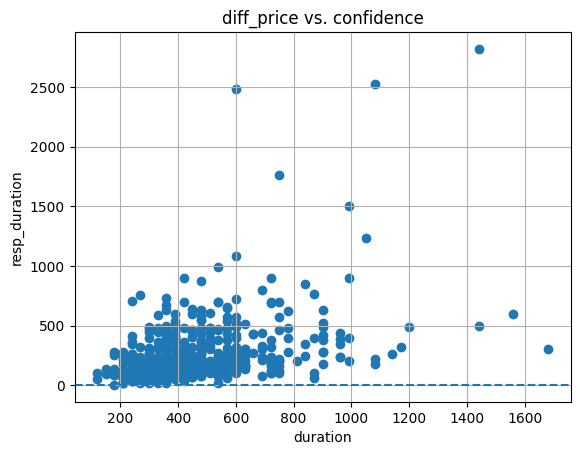

In [3]:
from plot import plotVariables
plotVariables(data_expanded["duration"],data_expanded["resp_duration"])

In [4]:
data_expanded.loc[1,"response"]

'role=\'assistant\' content=\'{"duration":"25","ZusatzInfo":"Bitte geben Sie an, ob zusätzlich Fensterreinigung, Teppichreinigung, Bodenpflege, etc. erforderlich sind, sowie die genaue Aufteilung der 50\\u202fqm auf die einzelnen Räume.","complete":"0","confidence":"0.3","missverständliche Aspekte":"Nicht spezifiziert, ob die 50\\u202fqm die gesamte Raumfläche oder die zu reinigende Bodenfläche umfasst; fehlende Angaben zu Fenstern, Bodenbelag, etc.","Zu erbringende Leistungen:":"Reinigung aller Räume (Boden, Oberflächen), Grundreinigung.","Rechenweg":"Annahme 5 Minuten pro 10\\u202fqm → 50\\u202fqm / 10 = 5 Einheiten × 5\\u202fMinuten = 25\\u202fMinuten.","Kommentare":"Beschreibung unvollständig; weitere Angaben zu Fenstern, Bodenbelag und spezifischen Anforderungen nötig."}\' thinking=\'We need to respond only in JSON with specified fields: duration, ZusatzInfo, complete, confidence, missverständliche Aspekte, Zu erbringende Leistungen:, Rechenweg, Kommentare.\\n\\nThe user gave desc

In [5]:
import pandas as pd
from client import askGPT

In [16]:
systemprompt = """Du bist ein Sachbearbeiter einer Reinigungsagentur. Deine Aufgabe ist es aus Kundenanfragen verschiedene Informationen zu extrahieren, und als json auszugeben.
Response Schema:
{
"TürenAnzahl": "integer",
"TürenAlleInfos": "string",
"FensterAnzahl": "integer",
"FensterAlleInfos": "string",
"ZimmerAnzahl": "integer",
"ZimmerAlleInfos": "string",
"BäderAnzahl": "integer",
"BäderAlleInfos": "string",
"BödenQuadratmeter": "integer",
"BödenAlleInfos": "string",
"AlleRestlichenInfos": "string"
}

"""

#print(askGPT("you are a pirate","who are you?"))

In [18]:
data_expanded.iloc[1,]["comment_price"]
data_expanded.iloc[1,]["comment_important"]
print(askGPT(systemprompt,data_expanded.iloc[1,]["comment_price"]))
#data_expanded.iloc[1,"comment_important"]

############### content ###############

############### Message ###############
role='assistant' content='' thinking='We got a garbled JSON. We need to produce the JSON with required fields: TürenAnzahl, TürenAlleInfos, FensterAnzahl, FensterAlleInfos, ZimmerAnzahl, ZimmerAlleInfos, BäderAnzahl, BäderAlleInfos, BödenQuadratmeter, BödenAlleInfos, AlleRestlichenInfos. We have info from the user: ":\n\n-30.50\n\n  \t\t\n  \t\t\t\t\n \t\t\t\n \t\t\t \t\t\t \t  \n \t\t\t \t\t\t \n \t\t\t \t\t\t \n \t\t\t \t\t\t \t\t \t\t\n \t\t\t \t\t\t \t\t\t\t\n \t\t\t ' images=None tool_calls=None
role='assistant' content='' thinking='We got a garbled JSON. We need to produce the JSON with required fields: TürenAnzahl, TürenAlleInfos, FensterAnzahl, FensterAlleInfos, ZimmerAnzahl, ZimmerAlleInfos, BäderAnzahl, BäderAlleInfos, BödenQuadratmeter, BödenAlleInfos, AlleRestlichenInfos. We have info from the user: ":\n\n-30.50\n\n  \t\t\n  \t\t\t\t\n \t\t\t\n \t\t\t \t\t\t \t  \n \t\t\t \t\t\t \n \t\t\t \t\t\

In [21]:
data_expanded["id"]

0      356405
1      489098
2      359596
3      726707
4      305492
        ...  
992    880539
994    828383
995    502682
997    518834
998    436146
Name: id, Length: 638, dtype: int64

In [33]:
data_expanded["comment_price"].apply(str)

0      Steckbrief - das Wichtigste zum Auftrag:\r\n\r...
1      Steckbrief - das Wichtigste zum Auftrag:\r\n\r...
2      Steckbrief - das Wichtigste zum Auftrag:\r\n\r...
3      Steckbrief - das Wichtigste zum Auftrag:\r\n\r...
4      75m2 Wohnung, fast leer Entsorgung von einigen...
                             ...                        
992    Steckbrief - das Wichtigste zum Auftrag:\r\n\r...
994    Steckbrief - das Wichtigste zum Auftrag:\r\n\r...
995    Steckbrief - das Wichtigste zum Auftrag:\r\n\r...
997    Steckbrief - das Wichtigste zum Auftrag:\r\n\r...
998    Steckbrief - das Wichtigste zum Auftrag:\r\n\r...
Name: comment_price, Length: 638, dtype: object

In [36]:
type(data_expanded["comment_price"].apply(str)[1])

str

In [43]:
data_expanded["id"].apply(str)[0]

'356405'

In [79]:
import chromadb

chroma_client = chromadb.Client()
collection = chroma_client.get_or_create_collection(name="umzug3",    metadata={
        "description": "my first Chroma collection"
    })

In [100]:
for id in data_expanded["id"][1:100]:

    
    collection.upsert(
        ids=str(i),
        documents=str(data_expanded["comment_price"][data_expanded["id"]==id]),
        metadatas={"duration":str(data_expanded["duration"][data_expanded["id"]==id])}
    )

In [91]:
data_expanded["duration"].apply(str)

0      420.0
1      270.0
2      900.0
3      570.0
4      420.0
       ...  
992    360.0
994    630.0
995    540.0
997    420.0
998    210.0
Name: duration, Length: 638, dtype: object

In [99]:
results = collection.query(
    query_texts=["Garten"], # Chroma will embed this for you
    n_results=10 # how many results to return
)



print(results.keys())
print("\n\n")
print(results)
print("\n\n")

print(results['ids'])

dict_keys(['ids', 'embeddings', 'documents', 'uris', 'included', 'data', 'metadatas', 'distances'])



{'ids': [['489098']], 'embeddings': None, 'documents': [['13    Steckbrief - das Wichtigste zum Auftrag:\\r\\n\\r...\nName: comment_price, dtype: object']], 'uris': None, 'included': ['metadatas', 'documents', 'distances'], 'data': None, 'metadatas': [[{'duration': '13    390.0\nName: duration, dtype: float64'}]], 'distances': [[1.7552826404571533]]}



[['489098']]
